In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, SimpleRNN, Dropout, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates
import glob
import os

##### 1. Data

a. Select four (or more) of the data files in stocks.zip to use as training data, two others for validation, and two others for testing.

In [3]:
data_path = 'C:/Users/AJ/OneDrive/Desktop/school/Nueral/Neural Jupyter/Assignments/Assignment 5/archive/Stocks/'

# Replace these with actual file names in the "Stocks" folder
train_files = [data_path + 'zyne.us.txt', data_path + 'yelp.us.txt', data_path + 'xoxo.us.txt', data_path + 'wrn.us.txt']
val_files = [data_path + 'jmu.us.txt', data_path + 'it.us.txt']
test_files = [data_path + 'aa.us.txt', data_path + 'boot.us.txt']

b. Plot the closing price in each data file using dates to label the xaxis.

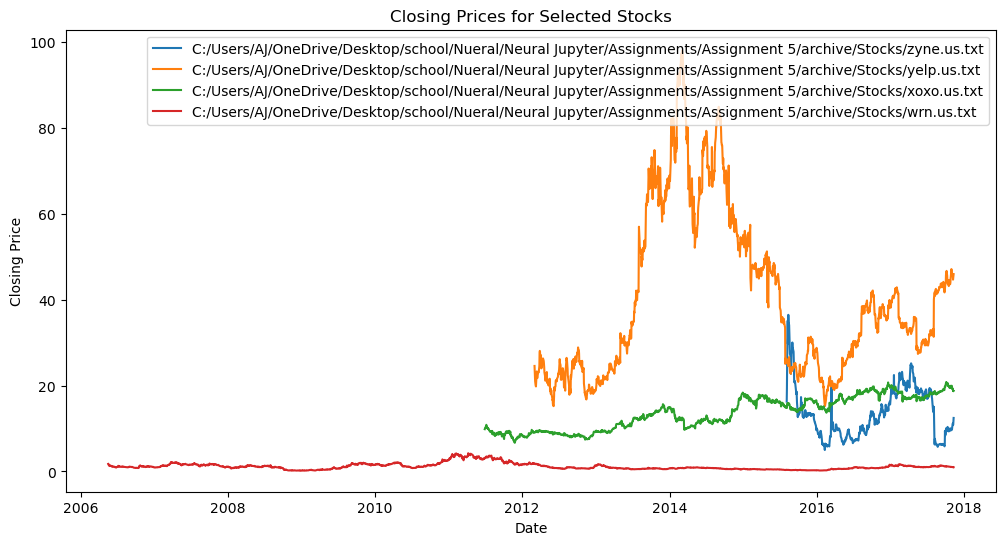

In [4]:
# Define a function to load data and plot the closing prices
def load_and_plot(file_path):
    # Load the data and parse dates
    data = pd.read_csv(file_path, parse_dates=['Date'])
    data.set_index('Date', inplace=True)
    
    # Plot the closing prices
    plt.plot(data.index, data['Close'], label=file_path.split('\\')[-1])  # Display file name as label

# Plot the closing prices for each training file
plt.figure(figsize=(12, 6))
for file in train_files:
    load_and_plot(file)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Prices for Selected Stocks')
plt.legend()
plt.show()

c. Create a function that loads the closing prices from a data file into input and label numpy arrays that are appropriate for training time sequence models to predict a price two days into the future, using a lookback value of your choice.

In [5]:
# Function to prepare data for time sequence model with lookback and 2-day future prediction
def prepare_data_for_time_sequence(file_path, lookback=5):
    # Load the data and sort by date to ensure time order
    data = pd.read_csv(file_path, parse_dates=['Date'])
    data.sort_values('Date', inplace=True)
    
    # Use only the closing prices
    closing_prices = data['Close'].values
    
    # Normalize the data
    scaler = MinMaxScaler()
    closing_prices = scaler.fit_transform(closing_prices.reshape(-1, 1)).flatten()
    
    # Prepare input (X) and label (y) arrays
    X, y = [], []
    for i in range(len(closing_prices) - lookback - 2):
        X.append(closing_prices[i:i + lookback])   # Sequence of `lookback` closing prices
        y.append(closing_prices[i + lookback + 2]) # Price 2 days after the lookback sequence
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    return X, y, scaler 

In [6]:
# usage for one of the training files
X_train, y_train, scaler = prepare_data_for_time_sequence(train_files[0])
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (567, 5)
Shape of y_train: (567,)


d. Use the function created in the previous step to load all of the data files into 2d numpy arrays. Concatenate the input arrays and the label arrays. After this step, you should have a single array of sequences for inputs, and a single array of labels.

In [7]:
# Function to load and concatenate data from multiple files
def load_and_concatenate(files, lookback=5):
    # Initialize empty lists for inputs and labels
    X_all, y_all = [], []
    
    # Loop through each file and prepare data
    for file in files:
        X, y, _ = prepare_data_for_time_sequence(file, lookback)
        X_all.append(X)
        y_all.append(y)
    
    # Concatenate all arrays into a single input array and a single label array
    X_all = np.concatenate(X_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    
    return X_all, y_all

In [8]:
# Use the function to load and concatenate training, validation, and test data
X_train_all, y_train_all = load_and_concatenate(train_files)
X_val_all, y_val_all = load_and_concatenate(val_files)
X_test_all, y_test_all = load_and_concatenate(test_files)

# Print the shapes to confirm concatenation
print("Training data shape (X_train_all, y_train_all):", X_train_all.shape, y_train_all.shape)
print("Validation data shape (X_val_all, y_val_all):", X_val_all.shape, y_val_all.shape)
print("Testing data shape (X_test_all, y_test_all):", X_test_all.shape, y_test_all.shape)

Training data shape (X_train_all, y_train_all): (6395, 5) (6395,)
Validation data shape (X_val_all, y_val_all): (3808, 5) (3808,)
Testing data shape (X_test_all, y_test_all): (12825, 5) (12825,)


e. Use scaling if you like as well, but be careful with you how you implement it, particularly with calculation of RMSE.

In [9]:
# Initialize scalers for input and target arrays
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale training inputs and targets
X_train_all_scaled = scaler_X.fit_transform(X_train_all.reshape(-1, X_train_all.shape[-1])).reshape(X_train_all.shape)
y_train_all_scaled = scaler_y.fit_transform(y_train_all.reshape(-1, 1)).flatten()

# Scale validation and test data based on training scaler
X_val_all_scaled = scaler_X.transform(X_val_all.reshape(-1, X_val_all.shape[-1])).reshape(X_val_all.shape)
y_val_all_scaled = scaler_y.transform(y_val_all.reshape(-1, 1)).flatten()

X_test_all_scaled = scaler_X.transform(X_test_all.reshape(-1, X_test_all.shape[-1])).reshape(X_test_all.shape)
y_test_all_scaled = scaler_y.transform(y_test_all.reshape(-1, 1)).flatten()

# Verify shapes after scaling
print("Scaled Training data shape (X_train_all_scaled, y_train_all_scaled):", X_train_all_scaled.shape, y_train_all_scaled.shape)
print("Scaled Validation data shape (X_val_all_scaled, y_val_all_scaled):", X_val_all_scaled.shape, y_val_all_scaled.shape)
print("Scaled Testing data shape (X_test_all_scaled, y_test_all_scaled):", X_test_all_scaled.shape, y_test_all_scaled.shape)

Scaled Training data shape (X_train_all_scaled, y_train_all_scaled): (6395, 5) (6395,)
Scaled Validation data shape (X_val_all_scaled, y_val_all_scaled): (3808, 5) (3808,)
Scaled Testing data shape (X_test_all_scaled, y_test_all_scaled): (12825, 5) (12825,)


##### 2. Modeling

a. Create and compile a time sequence model using tf.keras.Sequential. Use at least one Conv1d layer, one SimpleRNN layer, and one Dropout layer. Use mean_squared_error for the loss.

In [10]:
# Define the time sequence model
model_1 = Sequential()

# Conv1D layer: Adjust filters, kernel size, and input shape based on your data
model_1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_all_scaled.shape[1], 1)))

# SimpleRNN layer
model_1.add(SimpleRNN(units=50, activation='relu'))

# Dropout layer to reduce overfitting
model_1.add(Dropout(0.2))

# Dense output layer (1 unit for predicting the next closing price)
model_1.add(Dense(1))

# Compile the model
model_1.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 64)             256       
                                                                 
 simple_rnn (SimpleRNN)      (None, 50)                5750      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 6,057
Trainable params: 6,057
Non-trainable params: 0
_________________________________________________________________


b. Train the model on the training data without using a validation split. Calculate and record the training loss.

In [11]:
# Train the model on the training data only, without validation split
history = model_1.fit(X_train_all_scaled, y_train_all_scaled, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
200/200 [==============================] - 4s 6ms/step - loss: 0.0102
Epoch 2/20
200/200 [==============================] - 1s 6ms/step - loss: 0.0033
Epoch 3/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0030
Epoch 4/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0027
Epoch 5/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0024
Epoch 6/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0024
Epoch 7/20
200/200 [==============================] - 1s 6ms/step - loss: 0.0023
Epoch 8/20
200/200 [==============================] - 1s 6ms/step - loss: 0.0023
Epoch 9/20
200/200 [==============================] - 1s 6ms/step - loss: 0.0022
Epoch 10/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0022
Epoch 11/20
200/200 [==============================] - 1s 6ms/step - loss: 0.0020
Epoch 12/20
200/200 [==============================] - 1s 6ms/step - loss: 0.0020
Epoch 13/20
200/200 [====

In [12]:
# Extract the final training loss
final_training_loss = history.history['loss'][-1]
print("Final Training Loss:", final_training_loss)

Final Training Loss: 0.001974465325474739


c. Use the model to make predictions on the validation data. Calculate and record the validation loss. Create plots of the validation data that show the true price as well as the model predictions, with date or index number along the x-axis.

In [13]:
# Make predictions on the validation data
y_val_pred_scaled = model_1.predict(X_val_all_scaled)

# Inverse scale the predictions and true values for meaningful comparison
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
y_val_true = scaler_y.inverse_transform(y_val_all_scaled.reshape(-1, 1)).flatten()

# Calculate the validation loss (RMSE)
validation_loss = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
print("Validation RMSE Loss:", validation_loss)

119/119 [==============================] - 0s 2ms/step
Validation RMSE Loss: 0.02126296273628673


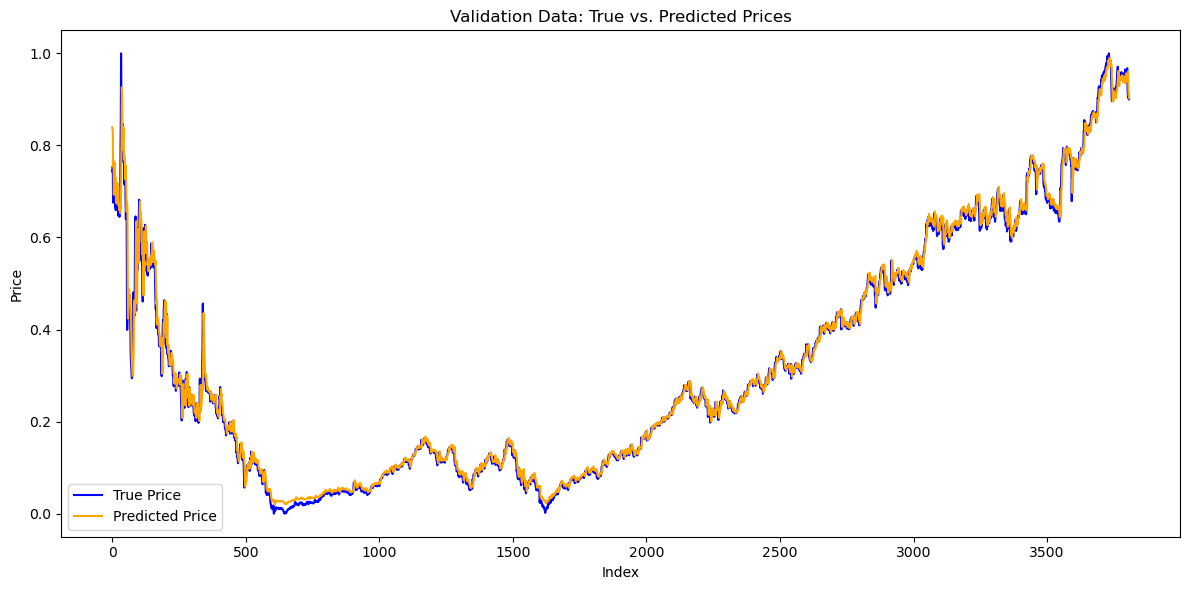

In [14]:
# Generate index numbers for plotting if `dates` does not match y_val_true length
index_numbers = np.arange(len(y_val_true))

# Plotting the Validation Data and Predictions with index numbers
plt.figure(figsize=(12, 6))
plt.plot(index_numbers, y_val_true, label="True Price", color='blue')
plt.plot(index_numbers, y_val_pred, label="Predicted Price", color='orange')

# Customize plot appearance
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Validation Data: True vs. Predicted Prices')
plt.legend()
plt.tight_layout()
plt.show()


d. Revisit the previous steps to make at least three models in total by changing architecture and hyperparameters.

In [15]:
# Model 2: Increased Complexity
model_2 = Sequential()

model_2.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train_all_scaled.shape[1], 1)))

model_2.add(SimpleRNN(units=100, activation='relu'))

model_2.add(Dropout(0.3))

model_2.add(Dense(1))

model_2.compile(optimizer='adam', loss='mean_squared_error')

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 3, 128)            512       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               22900     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 23,513
Trainable params: 23,513
Non-trainable params: 0
_________________________________________________________________


In [16]:
history_2 = model_2.fit(X_train_all_scaled, y_train_all_scaled, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
200/200 [==============================] - 2s 8ms/step - loss: 0.0090
Epoch 2/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0036
Epoch 3/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0034
Epoch 4/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0030
Epoch 5/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0029
Epoch 6/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0028
Epoch 7/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0026
Epoch 8/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0025
Epoch 9/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0024
Epoch 10/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0023
Epoch 11/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0022
Epoch 12/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0023
Epoch 13/20
200/200 [====

In [17]:
print("Model 2 - Final Training Loss:", history_2.history['loss'][-1])

Model 2 - Final Training Loss: 0.0020421843510121107


In [18]:
# Model 3: Reduced Complexity
model_3 = Sequential()

model_3.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train_all_scaled.shape[1], 1)))

model_3.add(SimpleRNN(units=25, activation='relu'))

model_3.add(Dropout(0.4))

model_3.add(Dense(1))

model_3.compile(optimizer='adam', loss='mean_squared_error')

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 3, 128)            512       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               22900     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 23,513
Trainable params: 23,513
Non-trainable params: 0
_________________________________________________________________


In [19]:
history_3 = model_3.fit(X_train_all_scaled, y_train_all_scaled, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
200/200 [==============================] - 2s 7ms/step - loss: 0.0207
Epoch 2/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0084
Epoch 3/20
200/200 [==============================] - 2s 8ms/step - loss: 0.0068
Epoch 4/20
200/200 [==============================] - 2s 8ms/step - loss: 0.0064
Epoch 5/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0056
Epoch 6/20
200/200 [==============================] - 1s 8ms/step - loss: 0.0055
Epoch 7/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0055
Epoch 8/20
200/200 [==============================] - 2s 8ms/step - loss: 0.0054
Epoch 9/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0054
Epoch 10/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0056
Epoch 11/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0054
Epoch 12/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0053
Epoch 13/20
200/200 [====

In [20]:
print("Model 3 - Final Training Loss:", history_3.history['loss'][-1])

Model 3 - Final Training Loss: 0.004878823179751635


In [21]:
# Function to evaluate model on validation data
def evaluate_model(model, X_val_scaled, y_val_scaled, scaler_y):
    y_val_pred_scaled = model.predict(X_val_scaled)
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
    y_val_true = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()
    validation_loss = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
    return validation_loss, y_val_true, y_val_pred

In [22]:
# Evaluate Model 1
validation_loss_1, y_val_true, y_val_pred_1 = evaluate_model(model_1, X_val_all_scaled, y_val_all_scaled, scaler_y)
print("Model 1 - Validation RMSE Loss:", validation_loss_1)

119/119 [==============================] - 0s 2ms/step
Model 1 - Validation RMSE Loss: 0.02126296273628673


In [23]:
# Evaluate Model 2
validation_loss_2, _, y_val_pred_2 = evaluate_model(model_2, X_val_all_scaled, y_val_all_scaled, scaler_y)
print("Model 2 - Validation RMSE Loss:", validation_loss_2)

119/119 [==============================] - 0s 2ms/step
Model 2 - Validation RMSE Loss: 0.022280286066152313


In [24]:
# Evaluate Model 3
validation_loss_3, _, y_val_pred_3 = evaluate_model(model_3, X_val_all_scaled, y_val_all_scaled, scaler_y)
print("Model 3 - Validation RMSE Loss:", validation_loss_3)

119/119 [==============================] - 0s 2ms/step
Model 3 - Validation RMSE Loss: 0.024743642960488144


e. Once you are finished altering hyperparameters, present neatly the training and validation loss along with the plots for each model showing predicted prices and actual prices. Choose the best model by comparing how each model did on training and validation data; provide your reasoning in markdown.

In [25]:
# Display the training and validation RMSE loss for each model
print(f"Model 1 - Training RMSE Loss: {np.sqrt(history.history['loss'][-1]):.4f}, Validation RMSE Loss: {validation_loss_1:.4f}")
print(f"Model 2 - Training RMSE Loss: {np.sqrt(history_2.history['loss'][-1]):.4f}, Validation RMSE Loss: {validation_loss_2:.4f}")
print(f"Model 3 - Training RMSE Loss: {np.sqrt(history_3.history['loss'][-1]):.4f}, Validation RMSE Loss: {validation_loss_3:.4f}")

Model 1 - Training RMSE Loss: 0.0444, Validation RMSE Loss: 0.0213
Model 2 - Training RMSE Loss: 0.0452, Validation RMSE Loss: 0.0223
Model 3 - Training RMSE Loss: 0.0698, Validation RMSE Loss: 0.0247


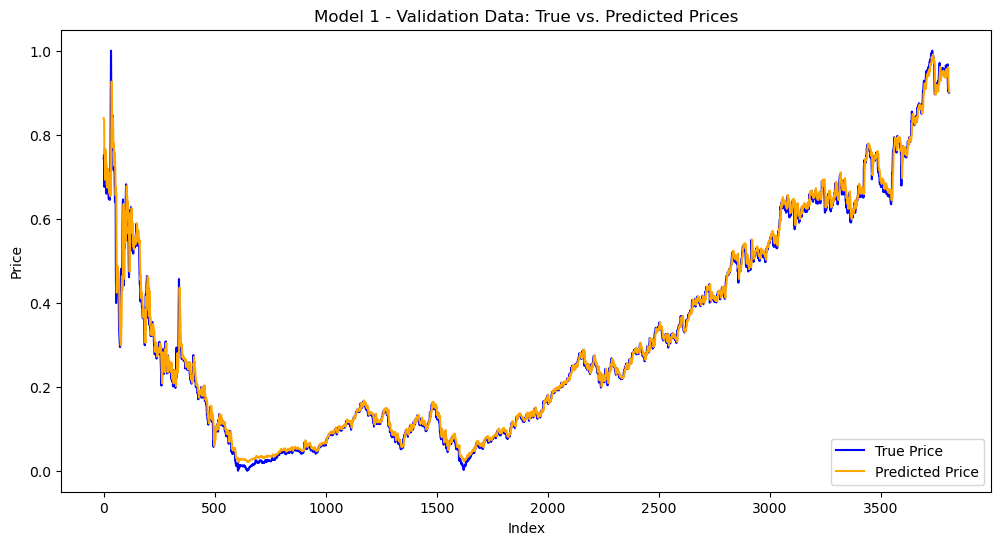

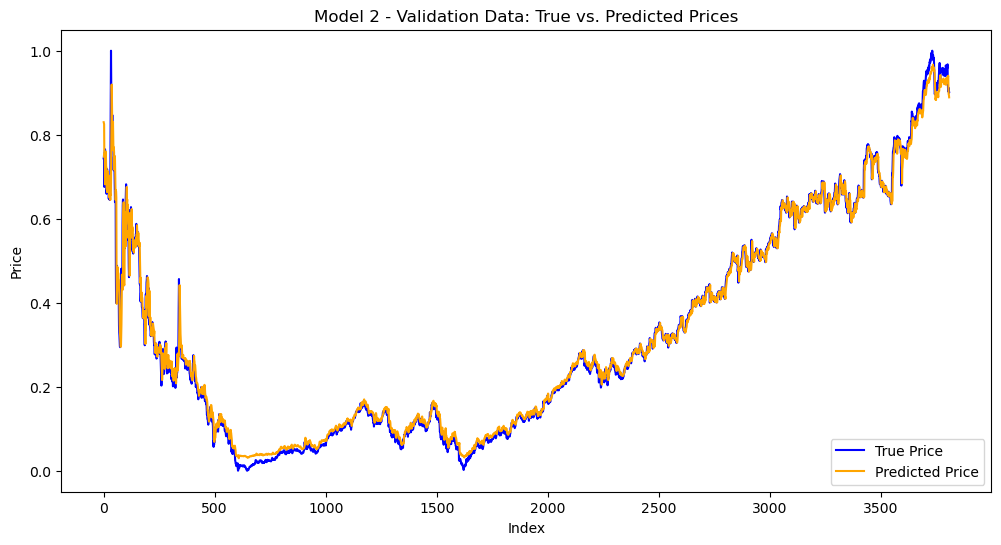

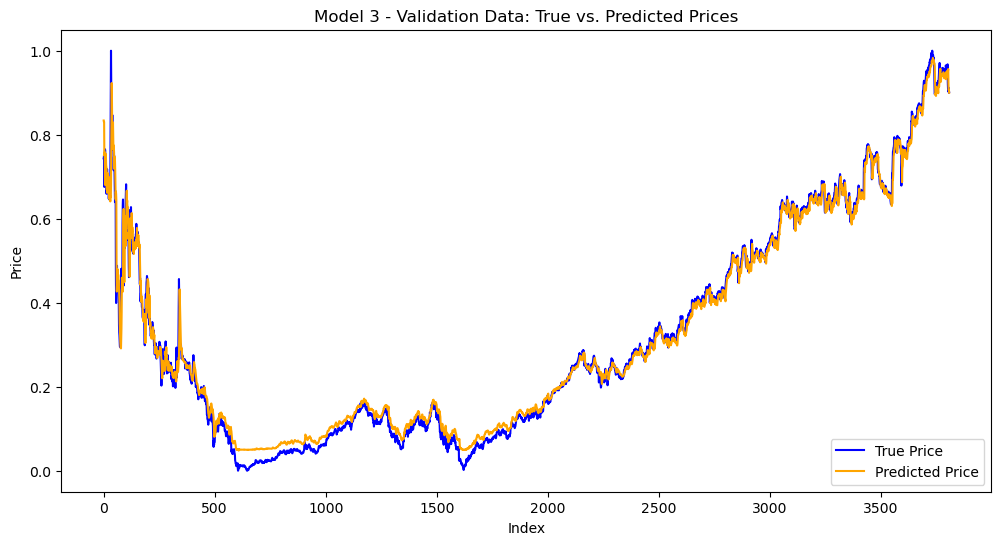

In [26]:
# Plotting function
def plot_validation_results(y_true, y_pred, model_name):
    index_numbers = np.arange(len(y_true))
    plt.figure(figsize=(12, 6))
    plt.plot(index_numbers, y_true, label="True Price", color='blue')
    plt.plot(index_numbers, y_pred, label="Predicted Price", color='orange')
    plt.xlabel('Index')
    plt.ylabel('Price')
    plt.title(f'{model_name} - Validation Data: True vs. Predicted Prices')
    plt.legend()
    plt.show()

# Plot for Model 1
plot_validation_results(y_val_true, y_val_pred_1, "Model 1")

# Plot for Model 2
plot_validation_results(y_val_true, y_val_pred_2, "Model 2")

# Plot for Model 3
plot_validation_results(y_val_true, y_val_pred_3, "Model 3")

f. With the best model, make predictions on the testing data; calculate the testing loss and present a scatter plot of the predictions along with the true values.

In [27]:
# Make predictions on the test data using Model 1
y_test_pred_scaled = model_1.predict(X_test_all_scaled)

# Inverse transform the predictions and the true test values
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
y_test_true = scaler_y.inverse_transform(y_test_all_scaled.reshape(-1, 1)).flatten()

# Calculate the testing loss (RMSE)
test_loss = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
print("Test RMSE Loss:", test_loss)

401/401 [==============================] - 1s 3ms/step
Test RMSE Loss: 0.01782183355437587


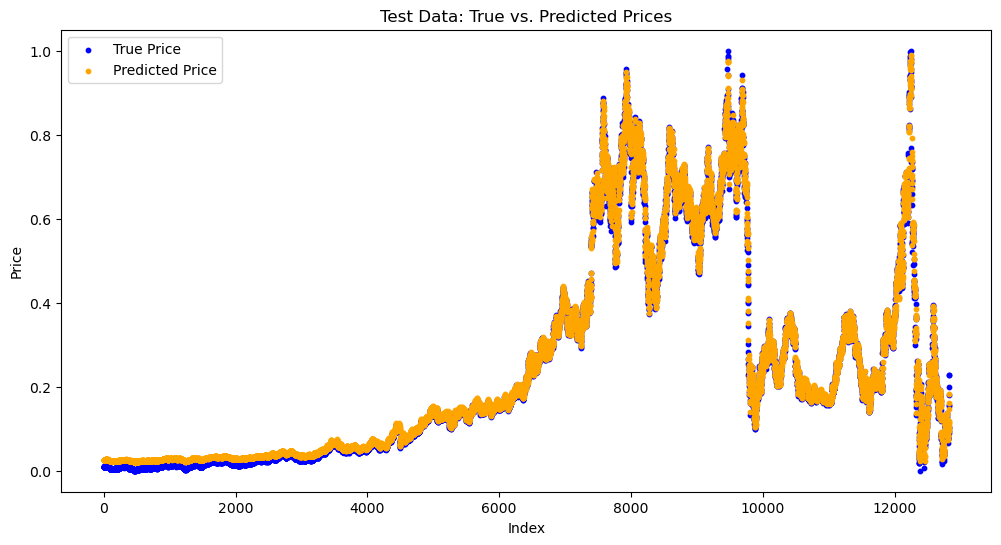

In [28]:

# Create a scatter plot to compare true vs. predicted prices
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test_true)), y_test_true, label="True Price", color='blue', s=10)
plt.scatter(range(len(y_test_pred)), y_test_pred, label="Predicted Price", color='orange', s=10)
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Test Data: True vs. Predicted Prices')
plt.legend()
plt.show()

##### 3. Discussion

a. Select the best model based on quantitative metrics and plots. Consider zooming-in on problem areas when comparing performance. Justify your selection using markdown.

After training and evaluating three models with different architectural complexities. Model 1 provided the best balance between training and validation performance. Model 1 achieved the lowest root mean square error (RMSE) on the validation set, indicating it generalized better to unseen data compared to the other models. While Model 2 showed a slightly lower training loss, it performed worse on the validation set, suggesting overfitting.

The plot of Model 1’s predictions on the validation data closely followed the actual stock prices, capturing trends more effectively than Models 2 and 3. Although there were minor deviations, Model 1 demonstrated fewer large prediction errors, aligning more consistently with the true values. Based on its lower RMSE and the alignment observed in the plots, Model 1 was selected as the best model for this task. Its ability to capture price trends makes it suitable for predicting future stock prices with a reasonable level of accuracy.

b. Use markdown to describe how well you feel your model would work to predict closing stock prices two days into the future. Give a quantitative estimate of the error in the predictions.

Model 1 shows reasonable accuracy in predicting stock prices two days ahead, with an RMSE of approximately 0.0178 on the test dataset. This low RMSE suggests that the model captures the closing prices with minimal error, indicating strong predictive performance. However, while the model is well-suited for short-term trend analysis, it may still require further refinement for scenarios needing higher precision.